# Выявление режима работы техники с наибольшим расходом топлива

В рамках этой задачи требуется найти такие показатели работы транспортного средства (ТС), при которых рясход топлива является максимальным.

## Препроцессинг данных

Для определения стиля вождения были выбраны следующие параметры:
1. Скорость движения (км/ч) - резкие скачки скорости указывают на резкий, опасный стиль вождения.
2. Телематические данные о высоте над уровнем моря (м) - резкие изменения положения транспортного средства в пространстве указывают на непредсказуемый и опасный выбор траектории движения.
3. Скорость вращения вала двигателя (обороты/с) - резкие изменения показателя оборотов двигателя указывают на спонтанное переключение передач ТС, что также указывает на неаккуратное вождение.

Для начала форматируем данные в удобную для обработки форму.

In [1]:
import os
import pandas as pd

In [2]:
# get all files with vehicle word in name
filenames = [filename for filename in os.listdir('./vehicle_dataset_public/') if filename.find('vehicle') != -1]

In [3]:
def get_unique_vehicles_sensors(filenames):
    vehicles, sensors = set(), set()
    for filename in filenames:
        vehicle_name, sensor_type, _ = filename.split('_')
        vehicles.add(vehicle_name)
        sensors.add(sensor_type)
    return list(vehicles), list(sensors)

In [4]:
vehicles, sensors = get_unique_vehicles_sensors(filenames)

In [5]:
# sort vehicle names and sensor types
vehicles.sort()
sensors.sort()

In [6]:
vehicles_data = pd.Series()
for vehicle_name in vehicles:
    vehicle = pd.Series()
    for sensor in sensors:
        sensor_df = pd.read_csv('./vehicle_dataset_public/'+'_'.join([vehicle_name, sensor, 'public.csv']), sep=';')
        vehicle[sensor] = sensor_df
    vehicles_data[vehicle_name] = vehicle

C:\Users\User\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  """Entry point for launching an IPython kernel.
C:\Users\User\Anaconda3\lib\site-packages\ipykernel_launcher.py:3: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  This is separate from the ipykernel package so we can avoid doing imports until


Реализуем функции для приведение типов данных в датасете:

In [7]:
def convert_number(num_as_string):
    """
        function converts numbers from string format N,n (replace all commas with dots) 
        to pandas Series float value format N.n (real number)
    """

    return num_as_string.str.replace(',', '.').astype('float')


def convert_date(date_as_string):
    """
        function converts date from string to datetime64 pandas date format
    """
    
    return date_as_string.astype('datetime64')


# replace commas with dots and change type from object to float64
for vehicle in vehicles:
    # fuelLevel dataset preproccess
    for sensor in sensors:
        sensor_data = vehicles_data[vehicle][sensor]
        values = sensor_data.columns
        for value in values:
            # three types: int | float | date
            # need to become: int->int str->float (if BEVALUE) and not int64 already
            # check correctness using print(vehicle, sensor, sensor_data, value)
            if sensor_data[value].dtype == 'object':
                date_like_columns = ['DTIME', 'STARTDATE', 'ENDDATE']
                if value in date_like_columns:
                    sensor_data[value] = convert_date(sensor_data[value])
                else:
                    sensor_data[value] = convert_number(sensor_data[value])
            # if not object do nothing (cause int64 -> (goes to) int64 by default)

In [8]:
# make dataframe with new features
vehicles_df = pd.DataFrame()
for vehicle in vehicles:
    # get only features generated by us
    generated_features = list(set(vehicles_data[vehicle].index) - set(sensors))
    vehicles_df[vehicle] = vehicles_data[vehicle][generated_features]

In [9]:
from matplotlib import pyplot as plt 

Удаляем из набора нереалистичные данные:

In [10]:
#delete imposible values from speed seria
vehicles_data['vehicle3'].speedAndHeight[6041:6043].SPEED = 0
vehicles_data['vehicle3'].speedAndHeight[6041:6043]

C:\Users\User\Anaconda3\lib\site-packages\pandas\core\generic.py:5303: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[name] = value


,DTIME,SPEED,HEIGHT
6041,2020-03-26 08:56:10,0,48.5
6042,2020-03-26 08:56:25,0,26.9


In [11]:
#round datatime values to minute
for vehicle in vehicles:
    vehicles_data[vehicle].speedAndHeight.DTIME = vehicles_data[vehicle].speedAndHeight.DTIME.dt.round('T')
    vehicles_data[vehicle].tachometer.DTIME = vehicles_data[vehicle].tachometer.DTIME.dt.round('T')

In [12]:
#round datatime values to minute
for vehicle in vehicles:
    for bevalue in range(1, len(vehicles_data[vehicle].fuelLevel.BEVALUE) - 1) :
        if (vehicles_data[vehicle].fuelLevel.BEVALUE[bevalue] == 0):
            vehicles_data[vehicle].fuelLevel.BEVALUE[bevalue] = (vehicles_data[vehicle].fuelLevel.BEVALUE[bevalue + 1] + vehicles_data[vehicle].fuelLevel.BEVALUE[bevalue - 1])/2
        

C:\Users\User\Anaconda3\lib\site-packages\ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """


In [13]:
vehicles_data['vehicle1'].fuelLevel[50:100]

,DTIME,BEVALUE
50,2020-01-14 10:18:03,48.5
51,2020-01-14 10:19:03,49.0
52,2020-01-14 10:20:03,49.6
53,2020-01-14 10:21:03,49.4
54,2020-01-14 10:22:03,48.9
55,2020-01-14 10:23:03,48.5
56,2020-01-14 10:24:03,48.5
57,2020-01-14 10:25:03,48.3
58,2020-01-14 10:26:03,48.3
59,2020-01-14 10:27:03,48.4


## Вычисление признаков

В последующем анализе с целью определения показателей работы ТС, при которых происходит наибольший расход топлива, будут использоваться такие параметры, как скорость движения ТС, скорость оборотов вала двигателя и непосредственно уровень топлива в баке ТС. 


Для вычисления расхода топлива за некоторый короткий промежуток времени и вычисления соответствующих значений скорости движения и скорости вращения вала двигателя используем метод скользящего окна. В случае с уровнем топлива берем разность значений по краям окна, с случае скорости движения и скорости вращения - среднее значение крайних значений окна. Ширина окна эмпирически была определена равной 2 секундам, шаг окна - 1 секунда.

Для большей репрезентативности выборки значения по всем ТС поставим в один ряд.

In [174]:
import numpy as np

In [175]:
# sliding window for speed
#vehicles_data_fuel_lvl_dif = pd.Series()
vehicles_data_fuel_lvl_dif = pd.DataFrame()
w_length = 2  # window length (sec)
w_step = 1  # window step  (sec)
 
fuel_lvl_dif = []
window_speed_mean = []
window_tachometer_mean = []
    
for vehicle in vehicles:
    current_vehicle = vehicles_data[vehicle]
    
    current_fuel_lvl_list = current_vehicle.fuelLevel.BEVALUE
    current_speed_list = current_vehicle.speedAndHeight.SPEED
    current_tachometer_list = current_vehicle.tachometer.BEVALUE
    
    w_start = np.arange(0, len(current_fuel_lvl_list) - w_length, w_step) 
    #vehicles_data_fuel_lvl_dif[vehicle] = pd.DataFrame()

 
    
    for n in w_start:
        fuel_lvl_dif.append(current_fuel_lvl_list[n + w_length] - current_fuel_lvl_list[n])
        window_speed_mean.append((current_speed_list[n + w_length] + current_speed_list[n])/2)
        window_tachometer_mean.append((current_tachometer_list[n + w_length] + current_tachometer_list[n])/2)
        
    
vehicles_data_fuel_lvl_dif['fuel_lvl_dif'] = fuel_lvl_dif
vehicles_data_fuel_lvl_dif['window_speed_mean'] = window_speed_mean
vehicles_data_fuel_lvl_dif['window_tachometer_mean'] = window_tachometer_mean
    

In [176]:
vehicles_data_fuel_lvl_dif[vehicles_data_fuel_lvl_dif['fuel_lvl_dif'] <-40]

,fuel_lvl_dif,window_speed_mean,window_tachometer_mean
290,-42.300,10.5,1200.0
2530,-42.375,99.5,3600.0
9653,-44.475,30.5,1840.0
10655,-42.525,0.0,832.0
10965,-43.050,28.5,1328.0
...,...,...,...
76329,-45.075,94.5,2571.0
76387,-43.125,103.0,2828.0
76779,-54.750,31.5,1529.5
77294,-52.875,47.5,2182.5


Вычислим 0.005-квантиль, чтоб найти максимальные возможные значения расхода топлива в промежуток времени, равный 2 секундам.

In [177]:
max_fuel_lost = np.quantile(vehicles_data_fuel_lvl_dif['fuel_lvl_dif'], 0.005)
max_fuel_lost

-28.199999999999996

In [217]:
vehicles_data_max_fuel_lost = vehicles_data_fuel_lvl_dif[vehicles_data_fuel_lvl_dif['fuel_lvl_dif'] <-28]

In [178]:
import seaborn as sns

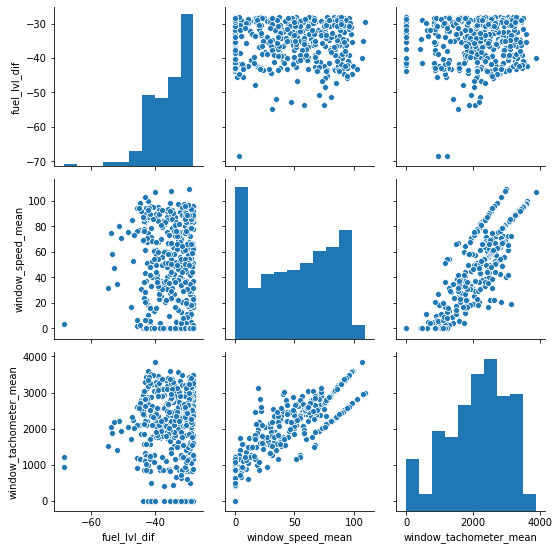

In [218]:
%config InlineBackend.figure_format = 'png' # формат изображений PNG, для сокращения времени отрисовки графиков       
sns.pairplot(vehicles_data_max_fuel_lost)

In [219]:
corrdf = vehicles_data_max_fuel_lost.corr(method='pearson') # method= {‘pearson’, ‘kendall’, ‘spearman’} или функция
print (corrdf)

                        fuel_lvl_dif  window_speed_mean  \
fuel_lvl_dif                1.000000          -0.020815   
window_speed_mean          -0.020815           1.000000   
window_tachometer_mean      0.020344           0.871469   

                        window_tachometer_mean  
fuel_lvl_dif                          0.020344  
window_speed_mean                     0.871469  
window_tachometer_mean                1.000000  


По графику можно сделать вывод, что значения скорости движения и скорости оборотов двигателя при высоких затратах топлива коррелируют с коэффициентом корреляции, равным 0.87. 

Для определения режима работы ТС, при котором расход топлива максимален, находим зависимость между скоростью движения ТС и скоростью оборотов двигателя с помощью метода линейной регрессии.

In [213]:
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error

In [205]:
window_speed_mean = vehicles_data_max_fuel_lost['window_speed_mean']
window_tachometer_mean = vehicles_data_max_fuel_lost['window_tachometer_mean']

В этом случае не принципиально, какой параметр будет являться независимой величиной, а какой зависимой, так как цель найти их соотношение.

In [206]:
Xtrn, Xtest, Ytrn, Ytest = train_test_split(window_speed_mean, window_tachometer_mean, test_size=0.25)
Xtrn.shape, Xtest.shape, Ytrn.shape, Ytest.shape

((300,), (100,), (300,), (100,))

In [207]:
Xtrn = Xtrn.values.reshape(-1, 1)
Xtest = Xtest.values.reshape(-1, 1)
Ytrn = Ytrn.values.reshape(-1, 1)
Ytest = Ytest.values.reshape(-1, 1)

In [209]:
lr = LinearRegression()
lr.fit(Xtrn, Ytrn)
y_pred  = lr.predict(Xtest)

<Figure size 432x288 with 0 Axes>

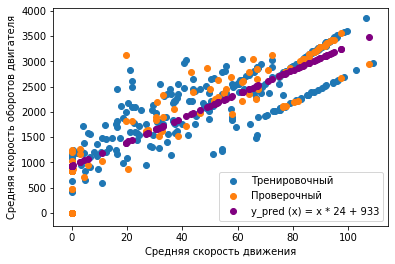

In [211]:
plt.figure()
fig, ax = plt.subplots()
ax.scatter(Xtrn, Ytrn, label=u'Тренировочный') 
ax.scatter(Xtest, Ytest, label=u'Проверочный') 
ax.scatter(Xtest, y_pred, color='purple', label="y_pred (x) = x * {:.0f} + {:.0f}".format(lr.coef_[0][0], lr.intercept_[0]))
ax.legend(loc="best")
ax.set_xlabel('Средняя скорость движения')
ax.set_ylabel('Средняя скорость оборотов двигателя')

plt.show()

In [215]:
print ("MAE Mean absolute error: {:.0f}".format( mean_absolute_error(Ytest, y_pred)))
print ("MSE Mean squared error: {:.0f}".format( mean_squared_error(Ytest, y_pred)))
print ("RMSE Root Mean Squared Error: {:.0f}".format(np.sqrt( mean_squared_error(Ytest, y_pred) )))
print ("R2 of Linear Regression (1 is perfect): {:.3f}".format( r2_score(Ytest, y_pred)))

y_pred (x) = x * 25 + 868

MAE Mean absolute error: 336
MSE Mean squared error: 201906
RMSE Root Mean Squared Error: 449
R2 of Linear Regression (1 is perfect): 0.812


С помощью линейной регрессии было получено следующее соотношение:


*tachometer_value = speed * 25 + 868,*

где speed - скорость движения ТС, tachometer_value - скорость вращения вала двигателя. Параметры, подходящие под это соотношение, являются режимом работы ТС с наибольшим расходом топлива.